# Проект - "Оценка результатов А/В-тестирования новой механизма рекомендаций на сайте интернет-магазина"

В период с 7 декабря 2020 года по 4 января 2021 года был проведен А/В-тест новой функциональности, а именно - нового механизма рекомендаций на сайте интернет-магазина.

Поставлена задача - проанализировать результаты теста. В рамках задачи предполагается выполнение следующих работ: 

1. Проверка корректности данных, их предобработка
2. Исследовательский анализ результатов теста
3. Формулирование вывода о качестве и результатах исследования

Для анализа результатов были предоставлены 4 датасета, содержащие следующие данные:

+ **`ab_project_marketing_events.csv`** — календарь маркетинговых событий на 2020 год со следующей структурой:
    - `name` — название маркетингового события;
    - `regions` — регионы, в которых будет проводиться рекламная кампания;
    - `start_dt` — дата начала кампании;
    - `finish_dt` — дата завершения кампании.
+ **`final_ab_new_users.csv`** — пользователи, зарегистрировавшиеся с 7 по 21 декабря 2020 года со следующей структурой:
    - `user_id` — идентификатор пользователя;
    - `first_date` — дата регистрации;
    - `region` — регион пользователя;
    - `device` — устройство, с которого происходила регистрация.
+ **`final_ab_events.csv`** — действия новых пользователей в период с 7 декабря 2020 по 4 января 2021 года со следующей структурой:
    - `user_id` — идентификатор пользователя;
    - `event_dt` — дата и время покупки;
    - `event_name` — тип события;
    - `details` — дополнительные данные о событии. Например, для покупок, `purchase,` в этом поле хранится стоимость покупки в долларах.
+ **`final_ab_participants.csv`** — таблица участников тестов со следующей структурой:
    - `user_id` — идентификатор пользователя;
    - `ab_test` — название теста;
    - `group` — группа пользователя.

# Подготовка

## Импорт библиотек и чтение данных

In [1]:
import pandas as pd
from io import BytesIO
import requests
import math as mth
import scipy.stats as st
from plotly import graph_objects as go
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

import psutil
import plotly.io as pio
pio.renderers.default='notebook'

from IPython.display import Image

In [2]:
#импортируем таблицы
spreadsheet_id = '17FYfKzEDrS0wbzzvB8UVuy_5Vgzld8R_R-2xZF2AJV0'
file_name = 'https://docs.google.com/spreadsheets/d/{}/export?format=csv'.format(spreadsheet_id)
r = requests.get(file_name)
final_ab_participants = pd.read_csv(BytesIO(r.content))

spreadsheet_id = '1ieuhv8ajykMdbc8WAcM1vvX-gpsE64loavBqyGcSopk'
file_name = 'https://docs.google.com/spreadsheets/d/{}/export?format=csv'.format(spreadsheet_id)
r = requests.get(file_name)
final_ab_events = pd.read_csv(BytesIO(r.content))

spreadsheet_id = '1AtN5QdkpmRMD1DYtzCgSIe0-QV_9XBHiPQDzrRr_vE0'
file_name = 'https://docs.google.com/spreadsheets/d/{}/export?format=csv'.format(spreadsheet_id)
r = requests.get(file_name)
final_ab_new_users = pd.read_csv(BytesIO(r.content))

spreadsheet_id = '1GY05m4U132se59Cn_4734p5u6L_OfJDA6_wbnxdEB7E'
file_name = 'https://docs.google.com/spreadsheets/d/{}/export?format=csv'.format(spreadsheet_id)
r = requests.get(file_name)
ab_project_marketing_events = pd.read_csv(BytesIO(r.content))

# Предобработка данных

## Таблица `final_ab_participants`

In [3]:
#посмотрим на размер таблицы и типы данных
final_ab_participants.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18268 entries, 0 to 18267
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  18268 non-null  object
 1   group    18268 non-null  object
 2   ab_test  18268 non-null  object
dtypes: object(3)
memory usage: 428.3+ KB


In [4]:
#оценим непосредственно таблицу
final_ab_participants.head()

,user_id,group,ab_test
0,D1ABA3E2887B6A73,A,recommender_system_test
1,A7A3664BD6242119,A,recommender_system_test
2,DABC14FDDFADD29E,A,recommender_system_test
3,04988C5DF189632E,A,recommender_system_test
4,482F14783456D21B,B,recommender_system_test


In [5]:
#оценим группировку значений по тесту и группе теста
final_ab_participants.groupby(['ab_test', 'group']).agg({'user_id': 'nunique'})

user_id
ab_test                 group         
interface_eu_test       A         5831
                        B         5736
recommender_system_test A         3824
                        B         2877

In [6]:
print('Количество полных дубликатов в данных:', sum(final_ab_participants.duplicated()))

Количество полных дубликатов в данных: 0


1. Таблица содержит 18268 строк и 3 столбца
2. В столбцах нет пропусков 
3. Автоматически присвоенные типы данных соответствуют действительности
4. В таблице присутствуют данные по двум разным тестам - в рамках исследования предполагается работа только с одним тестом

## Таблица `final_ab_new_users`

In [7]:
final_ab_new_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61733 entries, 0 to 61732
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     61733 non-null  object
 1   first_date  61733 non-null  object
 2   region      61733 non-null  object
 3   device      61733 non-null  object
dtypes: object(4)
memory usage: 1.9+ MB


In [8]:
final_ab_new_users.head()

,user_id,first_date,region,device
0,D72A72121175D8BE,2020-12-07,EU,PC
1,F1C668619DFE6E65,2020-12-07,N.America,Android
2,2E1BF1D4C37EA01F,2020-12-07,EU,PC
3,50734A22C0C63768,2020-12-07,EU,iPhone
4,E1BDDCE0DAFA2679,2020-12-07,N.America,iPhone


In [9]:
#В столбце first_data указана дата, но она определена как строковый тип данных, поэтому сделаем преобразования
final_ab_new_users['first_date'] = pd.to_datetime(final_ab_new_users['first_date'])

In [10]:
#Проверим на дубликаты
print('Количество полных дубликатов в данных:', sum(final_ab_new_users.duplicated()))

Количество полных дубликатов в данных: 0


In [11]:
final_ab_new_users['first_date'].min()

print('Min дата:',  final_ab_new_users['first_date'].min())
print('Max дата:',  final_ab_new_users['first_date'].max())

Min дата: 2020-12-07 00:00:00
Max дата: 2020-12-23 00:00:00


In [12]:
final_ab_new_users = final_ab_new_users[final_ab_new_users['first_date'] <= '2020-12-21']

In [13]:
final_ab_new_users['region'].value_counts()

EU           42340
N.America     8347
CIS           2900
APAC          2883
Name: region, dtype: int64

In [14]:
final_ab_new_users['device'].value_counts()

Android    25161
PC         14310
iPhone     11477
Mac         5522
Name: device, dtype: int64

In [15]:
#оставляем в датасете только пользователей из Европы, как того требует ТЗ
final_ab_new_users = final_ab_new_users[final_ab_new_users['region'] == 'EU']

1. В исходной таблице 61733 строки и 4 столбца
2. Пропусков нет
3. Строковый тип данных в столбце `first_date` преобразован в дату
4. В датасете обнаружены даты от 7 до 23 декабря 2020 года. По ТЗ дата остановки набора новых пользователей - 21 декабря 2020, поэтому из датасета удалены все строки с более поздней датой 
5. В датасете обнаружены регионы, отличные от региона "Европа", так как для проверки результатов теста нам они не понадобятся, данные по всем регионам кроме Европы были удалены

## Таблица `final_ab_events`

In [16]:
final_ab_events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440317 entries, 0 to 440316
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   user_id     440317 non-null  object 
 1   event_dt    440317 non-null  object 
 2   details     62740 non-null   float64
 3   event_name  440317 non-null  object 
dtypes: float64(1), object(3)
memory usage: 13.4+ MB


In [17]:
final_ab_events.head()

,user_id,event_dt,details,event_name
0,E1BDDCE0DAFA2679,2020-12-07 20:22:03,99.99,purchase
1,7B6452F081F49504,2020-12-07 09:22:53,9.99,purchase
2,9CD9F34546DF254C,2020-12-07 12:59:29,4.99,purchase
3,96F27A054B191457,2020-12-07 04:02:40,4.99,purchase
4,1FD7660FDF94CA1F,2020-12-07 10:15:09,4.99,purchase


In [18]:
#Проверим на дубликаты
print('Количество полных дубликатов в данных:', sum(final_ab_events.duplicated()))

Количество полных дубликатов в данных: 0


In [19]:
#преобразуем текст в дату
final_ab_events['event_dt'] = pd.to_datetime(final_ab_events['event_dt'])

In [20]:
print('Min дата события:',  final_ab_events['event_dt'].min())
print('Max дата события:',  final_ab_events['event_dt'].max())

Min дата события: 2020-12-07 00:00:33
Max дата события: 2020-12-30 23:36:33


In [21]:
#предположительно, данные в столбце details присутствуют только в строках события покупки, что логично
#проверим это выводом минимальной суммы
final_ab_events.groupby('event_name', as_index=False).agg({'details': 'min'})

,event_name,details
0,login,NaN
1,product_cart,NaN
2,product_page,NaN
3,purchase,4.99


1. В таблице 440317 записей и 4 столбца
2. Дубликатов нет
3. В столбце `details` присутствуют не все значения, так как в нем указана сумма покупки, поэтому данные есть только в транзакциях, зафиксировавших факт покупки
4. В столбце с `event_dt` потребовалось преобразование из строкого типа данных в дату
5. Любпытное наблюдение: согласно ТЗ, тестирование было завершено 4 января 2021 года, хотя данные о события присутствуют только до 30 декабря включительно. **Есть вероятность, что какая-то часть данных была утеряна при выгрузке.**

## Таблица  `ab_project_marketing_events`

In [22]:
ab_project_marketing_events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   name       14 non-null     object
 1   regions    14 non-null     object
 2   start_dt   14 non-null     object
 3   finish_dt  14 non-null     object
dtypes: object(4)
memory usage: 576.0+ bytes


In [23]:
ab_project_marketing_events.head()

,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03
1,St. Valentine's Day Giveaway,"EU, CIS, APAC, N.America",2020-02-14,2020-02-16
2,St. Patric's Day Promo,"EU, N.America",2020-03-17,2020-03-19
3,Easter Promo,"EU, CIS, APAC, N.America",2020-04-12,2020-04-19
4,4th of July Promo,N.America,2020-07-04,2020-07-11


In [24]:
ab_project_marketing_events['start_dt'] = pd.to_datetime(ab_project_marketing_events['start_dt'])
ab_project_marketing_events['finish_dt'] = pd.to_datetime(ab_project_marketing_events['finish_dt'])

1. Произведено преобразование данных из строкового типа в формат даты

# Анализ данных

## Анализ выборки пользователей

Так как основная задача - анализ событий, соберем один универсальный датафрейм, в рамках которого и будем работать. 

Так как в ТЗ указано, что нас интересуют: 
+ Новые пользователи, зарегистрировавшиеся до 21 декабря 2020 года
+ Из региона EU

Мы отберем пользователей из региона "Европа" из таблицы `final_ab_new_users` и присоединим к ней данные об участниках теста так, чтобы осталась только требуемая ЦА. 

In [25]:
#к таблице с "новыми" пользователями в регионе "Европа" присоединяем участников тестов и отбрасываем значения NaN
users = final_ab_new_users.merge(
    final_ab_participants, on='user_id', how='left'
).dropna()

In [26]:
#таким образом мы получаем только необходимые данные
users.head()

,user_id,first_date,region,device,group,ab_test
0,D72A72121175D8BE,2020-12-07,EU,PC,A,recommender_system_test
1,2E1BF1D4C37EA01F,2020-12-07,EU,PC,A,interface_eu_test
2,50734A22C0C63768,2020-12-07,EU,iPhone,B,interface_eu_test
7,E6DE857AFBDC6102,2020-12-07,EU,PC,B,recommender_system_test
8,E6DE857AFBDC6102,2020-12-07,EU,PC,B,interface_eu_test


In [27]:
#проверим, как распределились пользователи по тесту
users['ab_test'].value_counts()

interface_eu_test          10565
recommender_system_test     6351
Name: ab_test, dtype: int64

Проверим список пользователей на предмет пересечения с участниками другого теста. 

In [28]:
#соберем датафрейм, в котором сохраним количество различных тестов, в которых принимал участие каждый пользователь
two_tests_users = users.groupby('user_id', as_index=False).agg({'ab_test': 'nunique'})
two_tests_users = two_tests_users.rename(columns={'ab_test': 'number_of_tests'})
two_tests_users.head()

,user_id,number_of_tests
0,0002CE61FF2C4011,1
1,000ABE35EE11412F,1
2,001064FEAAB631A1,2
3,0010A1C096941592,1
4,001C05E87D336C59,1


In [29]:
#далее отбираем пользователей, которые принимали участие в целевом AB-тесте
recommender_system_test_users = users[users['ab_test'] == 'recommender_system_test']

In [30]:
#присоединяем количество тестов каждого пользователя к датафрейму с участниками целевого теста
recommender_system_test_users = recommender_system_test_users.merge(two_tests_users, on='user_id', how='left')
recommender_system_test_users.head()

,user_id,first_date,region,device,group,ab_test,number_of_tests
0,D72A72121175D8BE,2020-12-07,EU,PC,A,recommender_system_test,1
1,E6DE857AFBDC6102,2020-12-07,EU,PC,B,recommender_system_test,2
2,DD4352CDCF8C3D57,2020-12-07,EU,Android,B,recommender_system_test,2
3,831887FE7F2D6CBA,2020-12-07,EU,Android,A,recommender_system_test,1
4,4CB179C7F847320B,2020-12-07,EU,iPhone,B,recommender_system_test,1


In [31]:
print('Участников двух тестов в выборке:', len(recommender_system_test_users[recommender_system_test_users['number_of_tests'] == 2]))
print('Размер выборки:', len(recommender_system_test_users))

Участников двух тестов в выборке: 1602
Размер выборки: 6351


25.2% участников теста `recommender_system_test` также принимали участие во втором тесте `interface_eu_test`. Судя по названию второго теста, а также однообразию полей в выборке событий, ожидаемый эффект интерфейсного текста также направлен на повышение конверсии. Таким образом, обнаружен второй компрометирующий фактор. 

Так как нам известно, что группа А выступает контрольной группой в тестах, а значит использует не подвергнутую изменениям функциональность, можем предположить, что контрольная группа теста `interface_eu_test` может быть использована в нашем тесте условно "безопасно".

In [32]:
two_tests_users.head()

,user_id,number_of_tests
0,0002CE61FF2C4011,1
1,000ABE35EE11412F,1
2,001064FEAAB631A1,2
3,0010A1C096941592,1
4,001C05E87D336C59,1


In [33]:
#формируем два датасета в которых сохраним разные группы конкурирующего теста
interface_eu_test_a = users[(users['ab_test'] == 'interface_eu_test') & (users['group'] == 'A')]
interface_eu_test_b = users[(users['ab_test'] == 'interface_eu_test') & (users['group'] == 'B')]

In [34]:
#проверка доли участников теста
print(
    'Доля участников теста относительно общего количества новых пользователей из региона "Европа": {:.2f}%'.format(
        len(recommender_system_test_users)/len(final_ab_new_users[final_ab_new_users['region'] == 'EU'])*100)
)

Доля участников теста относительно общего количества новых пользователей из региона "Европа": 15.00%


1. Произведена проверка - в тесте действительно участвуют 15% новых пользователей региона EU, как того и требовало ТЗ
2. Сформина датасет с выборкой из 6351 пользователя, которые принимали участие в целевом тесте
3. Также идентифицированы пользователи, принявшие участие одновременно в двух тестах

## Анализ результатов А/В-теста

In [35]:
#формируем таблицу, в которой останутся только пользователи, вошедшие в пул участников теста
ab_events = final_ab_events[final_ab_events['user_id'].isin(recommender_system_test_users['user_id'])]
print('Количество событий, совершенных пользователями, входящими в выборку нашего теста:', len(ab_events))

Количество событий, совершенных пользователями, входящими в выборку нашего теста: 23420


In [36]:
#далее соединяем события с пользователями и получаем один общий датасет, где можем наблюдать детализированные данные по пользователю
ab_events = ab_events.merge(recommender_system_test_users, on='user_id', how='inner')

Сделаем дополнительную проверку количества пользователей - для всех ли пользователей из выборки присутствуют события в таблице операций. 

In [37]:
print('Количество уникальных идентификаторов пользователей в таблице событий:', len(ab_events['user_id'].unique()))

Количество уникальных идентификаторов пользователей в таблице событий: 3481


Таким образом, только 54.8% пользователей сгенерировали события. 

### Проверка гипотезы о равенствен долей для полной выборки

In [38]:
#построим сводную таблицу и оценим цифры конверсии из события в событие
events_users = ab_events.pivot_table(
    index='event_name',
    columns='group',
    values='user_id',
    aggfunc='nunique'
).reindex(["login", "product_page", "product_cart", "purchase"]) #реиндексом расположим события в нужном порядке

events_users

group,A,B
event_name,,
login,2604,877
product_page,1685,493
product_cart,782,244
purchase,833,249


In [39]:
#для упрощения получения доли по событию относительно количества пользователей на первом шаге, 
users = recommender_system_test_users.groupby('group')['user_id'].nunique().to_frame().reset_index()
users.loc[3] = ['a_group_total', len(recommender_system_test_users['user_id'].unique())]
users = users.set_index(users.columns[0])
users

,user_id
group,
A,3634
B,2717
a_group_total,6351


In [40]:
#функция будет принимать значения для групп, доли по событиям внутри которых по хотим посчитать 

def group_z_test(group1, group2):
    for event in events_users.index: #для каждого события в индексе датафрейма с событиями и количесвом юзеров мы начинаем цикл
        successes = events_users.loc[event] #в эту переменную сохраняем строку с количеством "успехов" по текущему событию
        trials = users.loc[[group1, group2]]['user_id'] #из датафрейма с "исходным" количеством получим данные по введенным группам
        alpha = 0.05 #критический уровень стат. значимости определим "жестко" в коде на уровне "стандарта"
        p1 = successes[group1]/trials[group1] #считаем пропорцию успехов для 1й группы
        p2 = successes[group2]/trials[group2] #считаем пропорцию успехов для 2й группы
        p_combined = (successes[group1] + successes[group2]) / (trials[group1] + trials[group2]) #комбинированная пропорция
        difference = p1 - p2 #вычисляем разницу пропорций в датасетах
        #вычисляем z-статистику 
        z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/trials[group1] + 1/trials[group2]))
        #задаем нормальное распределение
        distr = st.norm(0, 1)
        #берем z-статистику по модулю и считаем вероятность получения расхождения
        #далее умножаем на два, так как считаем, что распределение нормальное
        p_value = (1 - distr.cdf(abs(z_value))) * 2
        print('p-значение: ', p_value)
        if p_value < alpha:
            print('Отвергаем нулевую гипотезу: между долями есть значимая разница в рамках события', event)
        else:
            print('Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными в рамках события', event) 
        print()

In [41]:
group_z_test('A', 'B')

p-значение:  0.0
Отвергаем нулевую гипотезу: между долями есть значимая разница в рамках события login

p-значение:  0.0
Отвергаем нулевую гипотезу: между долями есть значимая разница в рамках события product_page

p-значение:  0.0
Отвергаем нулевую гипотезу: между долями есть значимая разница в рамках события product_cart

p-значение:  0.0
Отвергаем нулевую гипотезу: между долями есть значимая разница в рамках события purchase



In [42]:
print('Конверсия в покупку для группы А: {:.2f}%'.format(len(ab_events[(ab_events['group'] == 'A') & (ab_events['event_name'] == 'purchase')])  /\
len(recommender_system_test_users[recommender_system_test_users['group'] == 'A'])*100))

Конверсия в покупку для группы А: 69.79%


In [43]:
print('Конверсия в покупку для группы B: {:.2f}%'.format(len(ab_events[(ab_events['group'] == 'B') & (ab_events['event_name'] == 'purchase')])  /
len(recommender_system_test_users[recommender_system_test_users['group'] == 'B'])*100))

Конверсия в покупку для группы B: 24.29%


In [44]:
ab_events

,user_id,event_dt,details,event_name,first_date,region,device,group,ab_test,number_of_tests
0,831887FE7F2D6CBA,2020-12-07 06:50:29,4.99,purchase,2020-12-07,EU,Android,A,recommender_system_test,1
1,831887FE7F2D6CBA,2020-12-09 02:19:17,99.99,purchase,2020-12-07,EU,Android,A,recommender_system_test,1
2,831887FE7F2D6CBA,2020-12-07 06:50:30,NaN,product_cart,2020-12-07,EU,Android,A,recommender_system_test,1
3,831887FE7F2D6CBA,2020-12-08 10:52:27,NaN,product_cart,2020-12-07,EU,Android,A,recommender_system_test,1
4,831887FE7F2D6CBA,2020-12-09 02:19:17,NaN,product_cart,2020-12-07,EU,Android,A,recommender_system_test,1
...,...,...,...,...,...,...,...,...,...,...
23415,1484BBF124DB1B18,2020-12-27 10:53:34,NaN,login,2020-12-21,EU,PC,A,recommender_system_test,1
23416,BEF16764A13AEC34,2020-12-21 03:49:49,NaN,login,2020-12-21,EU,PC,B,recommender_system_test,2
23417,BEF16764A13AEC34,2020-12-22 18:52:25,NaN,login,2020-12-21,EU,PC,B,recommender_system_test,2
23418,BEF16764A13AEC34,2020-12-24 22:11:00,NaN,login,2020-12-21,EU,PC,B,recommender_system_test,2


In [45]:
# Код ревьюера
recommender_system_test_users['group'].value_counts()#, recommender_system_test_users_cut['group'].value_counts()

A    3634
B    2717
Name: group, dtype: int64

### Проверка гипотезы о равенствен долей для пользователей, участвовавших только в 1 тесте (целевом)

In [46]:
ab_events_second_test = ab_events[ab_events['number_of_tests'] == 1]
recommender_system_test_users_cut = recommender_system_test_users[recommender_system_test_users['number_of_tests'] == 1]

In [47]:
#построим сводную таблицу и оценим цифры конверсии из события в событие
events_users = ab_events_second_test.pivot_table(
    index='event_name',
    columns='group',
    values='user_id',
    aggfunc='nunique'
).reindex(["login", "product_page", "product_cart", "purchase"]) #реиндексом расположим события в нужном порядке

events_users

group,A,B
event_name,,
login,1939,655
product_page,1265,367
product_cart,589,184
purchase,613,191


In [48]:
#для упрощения получения доли по событию относительно количества пользователей на первом шаге, 
users = recommender_system_test_users.groupby('group')['user_id'].nunique().to_frame().reset_index()
users.loc[3] = ['a_group_total', len(recommender_system_test_users['user_id'].unique())]
users = users.set_index(users.columns[0])
users

,user_id
group,
A,3634
B,2717
a_group_total,6351


In [49]:
group_z_test('A', 'B')

p-значение:  0.0
Отвергаем нулевую гипотезу: между долями есть значимая разница в рамках события login

p-значение:  0.0
Отвергаем нулевую гипотезу: между долями есть значимая разница в рамках события product_page

p-значение:  0.0
Отвергаем нулевую гипотезу: между долями есть значимая разница в рамках события product_cart

p-значение:  0.0
Отвергаем нулевую гипотезу: между долями есть значимая разница в рамках события purchase



In [50]:
print('Конверсия в покупку для группы А: {:.2f}%'.format(len(ab_events_second_test[(ab_events_second_test['group'] == 'A') & (ab_events_second_test['event_name'] == 'purchase')])  /\
len(recommender_system_test_users_cut[recommender_system_test_users_cut['group'] == 'A'])*100))

Конверсия в покупку для группы А: 68.34%


In [51]:
print('Конверсия в покупку для группы B: {:.2f}%'.format(len(ab_events_second_test[(ab_events_second_test['group'] == 'B') & (ab_events_second_test['event_name'] == 'purchase')])  /\
len(recommender_system_test_users_cut[recommender_system_test_users_cut['group'] == 'B'])*100))

Конверсия в покупку для группы B: 24.26%


По результатам Z-теста наблюдается следующее: 

1. В группе А конверсию в покупку выше в 2.5 раза
2. Независимо от присутствия/отсутствия группы "двойных" пользователей в выборке, значения конверсии остаются сопоставимыми

## Распределение событий по датам

Посмотрим на календарь маркетинговых активностей и отберем те, что пересекаются с периодом теста. 

In [52]:
ab_project_marketing_events

,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03
1,St. Valentine's Day Giveaway,"EU, CIS, APAC, N.America",2020-02-14,2020-02-16
2,St. Patric's Day Promo,"EU, N.America",2020-03-17,2020-03-19
3,Easter Promo,"EU, CIS, APAC, N.America",2020-04-12,2020-04-19
4,4th of July Promo,N.America,2020-07-04,2020-07-11
5,Black Friday Ads Campaign,"EU, CIS, APAC, N.America",2020-11-26,2020-12-01
6,Chinese New Year Promo,APAC,2020-01-25,2020-02-07
7,Labor day (May 1st) Ads Campaign,"EU, CIS, APAC",2020-05-01,2020-05-03
8,International Women's Day Promo,"EU, CIS, APAC",2020-03-08,2020-03-10
9,Victory Day CIS (May 9th) Event,CIS,2020-05-09,2020-05-11


In [53]:
ab_project_marketing_events[
    (ab_project_marketing_events['start_dt'] >= '2020-11-30') & (
        ab_project_marketing_events['start_dt'] <= '2021-01-04')]

,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03
10,CIS New Year Gift Lottery,CIS,2020-12-30,2021-01-07


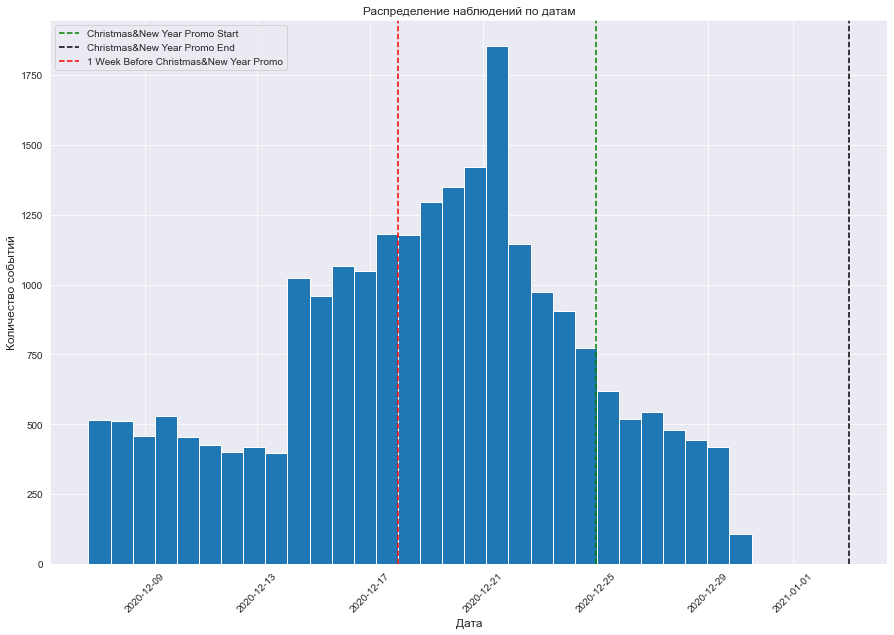

In [54]:
#визуализируем события
x = ab_events['event_dt']
sns.set_style('darkgrid')

fig, ax = plt.subplots(figsize=(15, 10))
plt.grid(axis='both')
plt.xticks(rotation=45)
plt.title('Распределение наблюдений по датам')
plt.grid(axis='both')
plt.xlabel('Дата', fontsize=12)
plt.ylabel('Количество событий', fontsize=12)

ax.hist(x,
        bins=30
       )

plt.axvline(x='2020-12-25', color='green', linestyle='--', label='Christmas&New Year Promo Start')
plt.axvline(x='2021-01-03', color='black', linestyle='--', label='Christmas&New Year Promo End')
plt.axvline(x='2020-12-18', color='red', linestyle='--', label='1 Week Before Christmas&New Year Promo')

plt.legend()
plt.show()

Как мы можем видеть на графике, события в рамках тест имеют сильное пересечение с рождественской маркетинговой активностью. Кроме того, следуеют учитывать, что факт рождества (зеленая линия) сам-по-себе потенциально может быть признаком рост продаж, так как люди покупают подарки. 

Этот факт дополнительно компрометирует результаты теста. 

## Воронка конверсии

In [55]:
funnel_data = ab_events.groupby(['group', 'event_name'], as_index=False).agg(
    {'event_dt': 'count', 'user_id': 'nunique'}
).reindex([0, 2, 1, 3, 4, 6, 5, 7])
funnel_data

,group,event_name,event_dt,user_id
0,A,login,8124,2604
2,A,product_page,5227,1685
1,A,product_cart,2422,782
3,A,purchase,2536,833
4,B,login,2471,877
6,B,product_page,1327,493
5,B,product_cart,653,244
7,B,purchase,660,249


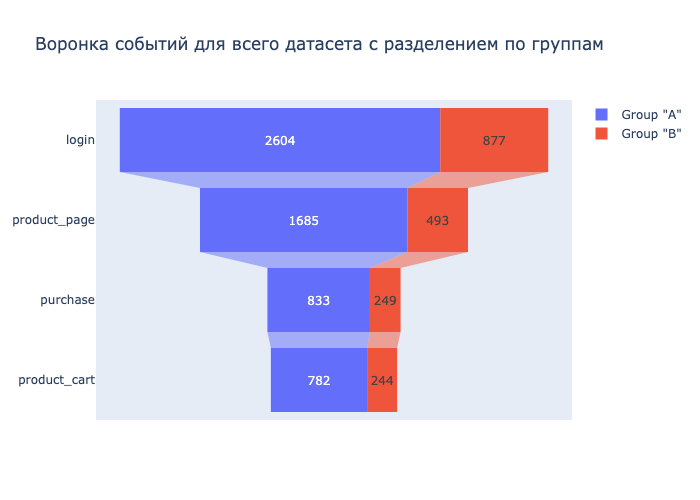

In [58]:
fig = go.Figure()

fig.add_trace(go.Funnel(
    name='Group "A"',
    y = funnel_data[funnel_data['group'] == 'A'].sort_values(by='user_id', ascending=False)['event_name'],
    x = funnel_data[funnel_data['group'] == 'A'].sort_values(by='user_id', ascending=False)['user_id']))


fig.add_trace(go.Funnel(
    name='Group "B"',
    y = funnel_data[funnel_data['group'] == 'B'].sort_values(by='user_id', ascending=False)['event_name'],
    x = funnel_data[funnel_data['group'] == 'B'].sort_values(by='user_id', ascending=False)['user_id']))

fig.update_layout(title_text="Воронка событий для всего датасета с разделением по группам")
#fig.show()

fig.write_image("/Users/rodion/Documents/plotly_export/funnel3.png")
img_bytes = fig.to_image(format="png")
Image(img_bytes)

In [57]:
print('Конверсия залогинившихся пользователей в покупки в группе А составляет: {:.2f}%'.format(events_users.loc['purchase']['A']/events_users.loc['login']['A']*100))
print('Конверсия залогинившихся пользователей в покупки в группе B составляет: {:.2f}%'.format(events_users.loc['purchase']['B']/events_users.loc['login']['B']*100))
print('Отношение конверсии в покупки в группе В к группе А: {:.2f}%'.format((events_users.loc['purchase']['B']/events_users.loc['login']['B'])/(events_users.loc['purchase']['A']/events_users.loc['login']['A'])*100))

Конверсия залогинившихся пользователей в покупки в группе А составляет: 31.61%
Конверсия залогинившихся пользователей в покупки в группе B составляет: 29.16%
Отношение конверсии в покупки в группе В к группе А: 92.24%


Мы наблюдаем снижение конверсии в покупки почти на 12% в испытуемой группе. В соответствии с ранее проверенной гипотезой о равенстве долей, такое отличие статистически значимо. Таким образом, мы можем говорить о провале теста. 

# Выводы

1. В процессе обработки данных был выявлен ряд проблем, компрометирующих данные, использованные для оценки результатов А/Б теста: 
    + В соответствии с ТЗ, дата окончания теста - 4 января 2021 года, однако в датасете отражены события только до конца 2020 года, что наводит на мысль о потере части данных в процессе обработки, либо выгрузки
    + Установлено, что в рамках теста происходит пересечение участников двух тестов 
    + Установлено, что события в рамках теста имеют значительное пересечение с рождественскими маркетинговыми активностями
    + Установлено, что только 55% пользователей очищенной выборки генерировали события в заданный период. Есть вероятность, что произошла ошибка учета активности пользователей, либо возникла проблема в процессе выгрузки данных
2. Результаты А/Б теста были подвергнуты анализу: 
    + В группе А конверсию в покупку выше в 2.5 раза
    + Независимо от присутствия/отсутствия группы "двойных" пользователей в выборке, значения конверсии остаются сопоставимыми
3. Установлено, что конверсия из события логина на сайте в событие покупки в группе В снизилась на 12%, что говорит о неуспехе тестирования новой функциональности

**Рекомендация -** слишком много различных факторов компрометируют результативность теста, поэтому воспринимать его результаты как максимально объективные не стоит. Если относительно тестируюемой инициативы были "большие" ожидания, стоит обдумать повторное тестирование в более изолированных условиях и уделить особое внимание сбору данных о проведенном тесте. 